In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
sns.set_style("whitegrid")
# Bigger font
# sns.set_context("poster")
sns.set_context("talk")
# Figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 4
# np.random.seed(123)

Mean Encoding has many names:
- Likelihood Encoding
- Target Encoding

It mostly consists on encoding each level of the categorical variable with its corresponding target mean.

## Why mean encoding?

label_encoding.png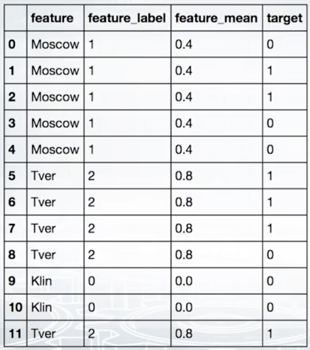

Because "Feature" is a categorical feature, Label encoding would be what comes to mind first.

But mean encoding is supposedly better. It is about encoding every city with the corresponding mean target, so feature_mean is created 0.4 = 2/5 (this comes from the target column).

- Label encoding gives random order. No correlation with the target.
- Mean encoding makes classes look more separable.

Using Gradient Boosting Trees.
- We can reach better loss with shorter(less deep) trees.

## When to use mean encoding?
- When there are categorical variables with a lot of levels.
- The plots below indicate 3 models with depth 7, 9 and 11
    - The AUC keeps increasing but we don't overfit (this would happen when the model's AUC gets to 1 on the TRAIN and on the VALIDATION set it just fails by decreasing). 
    - **If it doesn't overfit**, the trees need a huge number of splits to extract information from some variables. Some features can have 1600 split points. 

train_test_mean_encoding.png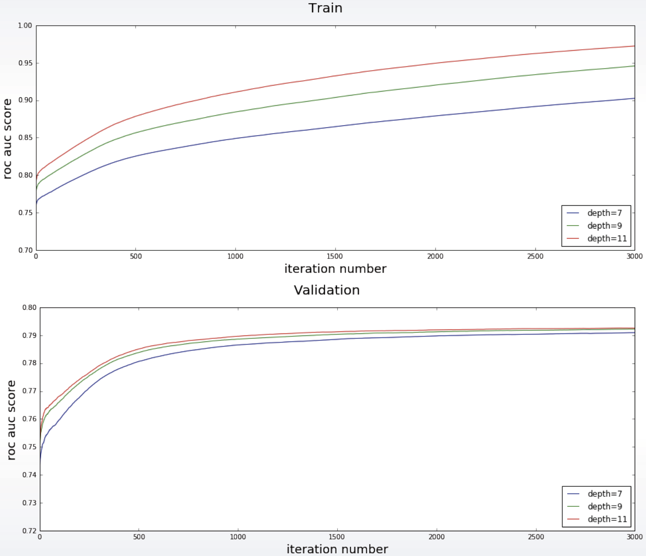

## Ways to calculate mean encoding?

For example, if we have binary levels. Goods = number of ones in a group, Bads = number of zeros

- Likelihood = Goods/(Goods + Bads) = mean(target)
- Weight of evidence = ln(Goods/Bads) * 100
- Count = Goods = sum(target)
- Diff = Goods - Bads

## How to do mean encoding?

1. Separate the data into train and validation.
2. Compute the mean of the target for certain column. For example, here we have 'Points' as the target and we can group by 'Team' because it is categorical and it is assumed to have many levels.

In [6]:
data = {'Team': ['Riders', 'Riders', 'Devils', 'Devils', 'Kings',
         'kings', 'Kings', 'Kings', 'Riders', 'Royals', 'Royals', 'Riders'],
         'Rank': [1, 2, 2, 3, 3,4 ,1 ,1,2 , 4,1,2],
         'Year': [2014,2015,2014,2015,2014,2015,2016,2017,2016,2014,2015,2017],
         'Points':[876,789,863,673,741,812,756,788,694,701,804,690]}
data = pd.DataFrame(data)
data.head()

,Team,Rank,Year,Points
0,Riders,1,2014,876
1,Riders,2,2015,789
2,Devils,2,2014,863
3,Devils,3,2015,673
4,Kings,3,2014,741


In [7]:
from sklearn.model_selection import train_test_split
train_new, val_new = train_test_split(data, test_size=0.2)

In [25]:
col = 'Team'
means = data.groupby(col)['Points'].mean()
train_new[col + '_mean_target'] = train_new[col].map(means)
val_new[col + '_mean_target'] = val_new[col].map(means)
train_new.head()

/Users/rgap/.virtualenvs/rgap-lectures/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rgap/.virtualenvs/rgap-lectures/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Team,Rank,Year,Points,Team_mean_target
0,Riders,1,2014,876,762.250000
3,Devils,3,2015,673,768.000000
2,Devils,2,2014,863,768.000000
5,kings,4,2015,812,812.000000
7,Kings,1,2017,788,761.666667


After repeating that process for every categorical column, we can use xgboost. In this case there was only one column.

In [33]:
import xgboost as xgb
dtrain = xgb.DMatrix(train_new.iloc[:,(train_new.columns != 'Team') & (train_new.columns != 'Points')], label=train_new['Points'].values)
dvalid = xgb.DMatrix(val_new.iloc[:,(val_new.columns != 'Team') & (train_new.columns != 'Points')], label=val_new['Points'].values)

evallist = [(dtrain, 'train'),(dvalid, 'eval')]
evals_result3 = {}

xgb_par = {'max_depth':100,
         'eval_metric':'rmse'}
model = xgb.train(xgb_par, dtrain, 3000, evals=evallist,verbose_eval=30,evals_result=evals_result3,early_stopping_rounds=200)

[0]	train-rmse:563.604	eval-rmse:557.102
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 200 rounds.
[30]	train-rmse:1.60038	eval-rmse:68.1456
[60]	train-rmse:0.012226	eval-rmse:68.3904
[90]	train-rmse:0.001006	eval-rmse:68.3922
[120]	train-rmse:0.001006	eval-rmse:68.3922
[150]	train-rmse:0.001006	eval-rmse:68.3922
[180]	train-rmse:0.001006	eval-rmse:68.3922
[210]	train-rmse:0.001006	eval-rmse:68.3922
Stopping. Best iteration:
[19]	train-rmse:9.70156	eval-rmse:66.8223



In [35]:
preds = model.predict(xgb.DMatrix(val_new.loc[:,(val_new.columns != 'Team') & (train_new.columns != 'Points')]))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,val_new.iloc[:, val_new.columns == 'Points'].values))
print(rmse)

68.39220282238342


#### There is overfitting. Only the train data was used to estimate mean encodings.

If we had done mean encoding before the train-validation split, the model wouldn't overfit.

Anyway, it essentially overfits because the mean-encoded feature becomes a good descriptor for the target. This is apparently known as **leakage from the target variable**.

We need to do some regularization first.

## Ways to do regularization

#### 1. CV loop inside train data (CV Loop and LOO regularization)

This consists on doing mean encoding for a fold by not using the data from that fold but from the rest of folds. 4-5 folds are enough.

**This may result in some NaNs. In that case, they filled with the global mean.**

This is an example using Leave one out.

leave_one_out_example.png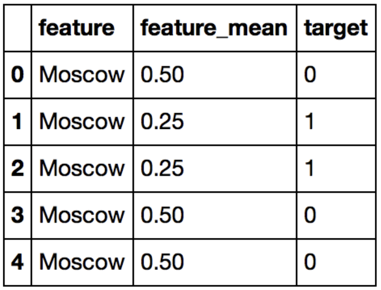

#### 2. Smoothing based on the size of the category

- If the category is very common, then we can trust the mean encoding.
- If the category is very rare, we can't.

With this method we use "alpha" as a regularizer.

$$\frac{mean(target)*nrows + globalmean*alpha}{nrows + alpha}$$

When alpha is very large, everything turns into the global mean, and it punishes rare categories. Smoothing can be combined with CV loop regularization.

#### 3. Adding random noise

Adding noise degrades the quality of encoding in the train data.

It is hard to make this method work. It is usually used together with LOO regularization.

#### 4. Sorting and calculating expanding mean on some permutation of the data

It is about using only rows from 0 to n-1 to calculate the encoding for row n.

- Least amount of leakage
- No hyper parameters
- But it produces irregular encoding quality
- It is implemented in "Catboost gradient boosting library", which is used in datasets with categorical features.

These methods are better explained in this video  https://www.coursera.org/learn/competitive-data-science/lecture/LGYQ2/regularization

It is better to try them out by using them with real data.

## Real example where to use mean encoding

**This is where it is a good moment to start finding a pipeline and model for the competition.**

https://www.kaggle.com/c/competitive-data-science-predict-future-sales

Task: **Forecast the total amount of products of each type that will be sold in every shop for the test set.**

Something important to take into account in this dataset is this field:

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

In [76]:
sales = pd.read_csv('data/sales_train.csv.gz')
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')
sales.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0


And that the test set is only data from the month November 2015, and it contains products and their shops and we have to predict the amount sold.

In [77]:
test = pd.read_csv('data/test.csv.gz')
test.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


## What categorical or ordinal features are there?

- item_id
- shop_id

Even 'date_block_num' but I don't think is it good to encode that one in this case.